Как правило, модели машинного обучения действуют в предположении, что матрица "объект-признак" является вещественнозначной, поэтому при работе с текстами сперва для каждого из них необходимо составить его признаковое описание. Для этого широко используются техники векторизации, tf-idf и пр. Рассмотрим их на примере датасета отзывов о банках.

In [44]:
import json

import bz2
import re
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [5]:
responses = []
with bz2.BZ2File('./data/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked']:
            responses.append(resp)

201030it [03:21, 996.76it/s] 


In [7]:
interesting_responses = [i for i in responses if 'отвратительно' in i['text']]
print(interesting_responses[0]['text'])

Банк отказывается возвращать депозит после окончания срока действия договора. Предлагает обращаться в ЦО, где в порядке живой очереди можно забирать не более 500$/день в порядке живой очереди. Налицо отвратительное отношение к вкладчикам. Советую всем обращаться с жалобой в ЦБ и роспотребнадзор.


In [19]:
regex = r'\b\w+\b'
' '.join(re.findall(regex, interesting_responses[0]['text'].lower()))

'банк отказывается возвращать депозит после окончания срока действия договора предлагает обращаться в цо где в порядке живой очереди можно забирать не более 500 день в порядке живой очереди налицо отвратительное отношение к вкладчикам советую всем обращаться с жалобой в цб и роспотребнадзор'

Сформируем выборку отзывов, предобработав их аналогичным образом, и вектор ответов:

In [20]:
responses = [i for i in responses if i['rating_grade'] is not None]
texts = [' '.join(re.findall(regex, i['text'].lower())) for i in responses]
ratings = [i['rating_grade'] for i in responses]

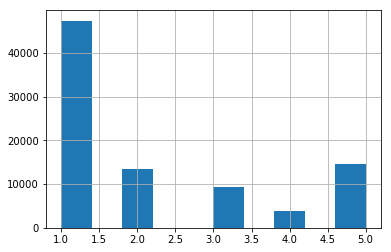

In [23]:
plt.hist(ratings)
plt.grid()

Самый очевидный способ формирования признакового описания текстов — векторизация.

Пусть у нас имеется коллекция текстов $D = \{d_i\}_{i=1}^l$ и словарь всех слов, встречающихся в выборке $V = \{v_j\}_{j=1}^d.$ В этом случае некоторый текст $d_i$ описывается вектором $(x_{ij})_{j=1}^d,$ где $$x_{ij} = \sum_{v \in d_i} [v = v_j].$$

Таким образом, текст $d_i$ описывается вектором количества вхождений каждого слова из словаря в данный текст.



In [24]:
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
vectorizer = CountVectorizer(encoding='utf8', min_df=5)
_ = vectorizer.fit(texts)


In [26]:
vectorizer.transform(texts[:1])

<1x76358 sparse matrix of type '<class 'numpy.int64'>'
	with 173 stored elements in Compressed Sparse Row format>

In [29]:
print(vectorizer.transform(texts[:1]).indices)
print(vectorizer.transform(texts[:1]).data)

[  626   817  1035  1098  1854  2532  2552  5191  5718  5720  5724  5796
  6549  6681  6854  7064  7139  7708  7739  7740  7741  9201  9216  9231
  9977  9996 10386 10529 10859 10901 11576 12355 12400 12401 12773 12873
 14535 14564 14571 14591 15124 15820 15961 16287 17444 17498 17499 18032
 18818 19932 19960 20104 20984 21630 22074 22461 23575 24462 24814 24815
 24845 25135 25398 25922 26017 26252 27039 27117 27336 28399 30000 30023
 30638 30715 30764 30765 30766 30767 30812 31544 31894 32528 33739 34340
 36612 38228 39068 41174 41233 41480 41557 41723 41814 41868 43215 44172
 45160 45638 46001 46155 46554 46590 48006 48432 48754 49174 49216 49451
 49564 49754 49994 50182 51201 51740 51790 52515 53306 53977 54853 55779
 56142 56271 56530 57141 57143 57876 58650 60680 61348 61599 61633 62136
 62306 62509 63426 63454 63457 63476 63588 63930 64539 64541 64849 64880
 64887 65678 65808 65812 65872 66139 66557 67001 67569 67571 67808 67878
 68262 68363 68455 68490 68496 70192 70539 72515 73

#### TF-IDF

Ещё один способ работы с текстовыми данными — TF-IDF (Term Frequency–Inverse Document Frequency). Рассмотрим коллекцию текстов $D$. Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте: $$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$ где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
Inverse Document Frequency $$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$ где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину: $$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D).$

Признаковым описанием одного объекта $d \in D$ будет вектор $\bigg(\text{tf-idf}(t,d, D)\bigg)_{t\in V}$, где $V$ – словарь всех слов, встречающихся в коллекции $D$.



In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
vectorizer = TfidfVectorizer(encoding='utf8', min_df=5)
_ = vectorizer.fit(texts)

In [32]:
vectorizer.transform(texts[:1])

<1x76358 sparse matrix of type '<class 'numpy.float64'>'
	with 173 stored elements in Compressed Sparse Row format>

In [33]:
print(vectorizer.transform(texts[:1]).indices)
print(vectorizer.transform(texts[:1]).data)

[75936 75219 74772 74695 74397 74201 73740 73727 73707 72515 70539 70192
 68496 68490 68455 68363 68262 67878 67808 67571 67569 67001 66557 66139
 65872 65812 65808 65678 64887 64880 64849 64541 64539 63930 63588 63476
 63457 63454 63426 62509 62306 62136 61633 61599 61348 60680 58650 57876
 57143 57141 56530 56271 56142 55779 54853 53977 53306 52515 51790 51740
 51201 50182 49994 49754 49564 49451 49216 49174 48754 48432 48006 46590
 46554 46155 46001 45638 45160 44172 43215 41868 41814 41723 41557 41480
 41233 41174 39068 38228 36612 34340 33739 32528 31894 31544 30812 30767
 30766 30765 30764 30715 30638 30023 30000 28399 27336 27117 27039 26252
 26017 25922 25398 25135 24845 24815 24814 24462 23575 22461 22074 21630
 20984 20104 19960 19932 18818 18032 17499 17498 17444 16287 15961 15820
 15124 14591 14571 14564 14535 12873 12773 12401 12400 12355 11576 10901
 10859 10529 10386  9996  9977  9231  9216  9201  7741  7740  7739  7708
  7139  7064  6854  6681  6549  5796  5724  5720  5

### Лемматизация и стемминг

Заметим, что одно и то же слово может встречаться в различных формах (например, "сотрудник" и "сотрудника"), но описанные выше методы интерпретируют их как различные слова, что делает признаковое описание избыточным. Устранить эту проблему можно при помощи лемматизации и стемминга.

###### Стемминг

Stemming – это процесс нахождения основы слова. В результате применения данной процедуры однокоренные слова, как правило, преобразуются к одинаковому виду.


Примеры стемминга:

Word  | Stem
------------- | -------------
вагон  | вагон
вагона |	вагон
вагоне |	вагон
вагонов |	вагон
вагоном |	вагон
вагоны |	вагон
важная |	важн
важнее |	важн
важнейшие |	важн
важнейшими | важн
важничал |	важнича
важно |	важн

In [35]:
import nltk

In [37]:
stemmer = nltk.stem.snowball.RussianStemmer()
print(stemmer.stem('машинное'), stemmer.stem('обучение'))

машин обучен


In [38]:
def stem_text(text, stemmer):
    tokens = text.split()
    return ' '.join(map(lambda w: stemmer.stem(w), tokens))

stemmed_texts = []
for t in tqdm(texts[:1000]):
    stemmed_texts.append(stem_text(t, stemmer))

100%|██████████| 1000/1000 [00:23<00:00, 42.49it/s]


In [40]:
print(texts[10])

отвратительное отношение к вкладчикам пришел пополнить свой вклад отказали сидят довольные и сытые сотрудники и ничего объяснять не собираются говорят мол к июлю все будет известно а что будет очередной банк который так легко готов потерять лицо и репутацию как заявляют клерки всего то


In [41]:
print(stemmed_texts[10])

отвратительн отношен к вкладчик пришел пополн сво вклад отказа сид довольн и сыт сотрудник и нич объясня не собира говор мол к июл все будет известн а что будет очередн банк котор так легк гот потеря лиц и репутац как заявля клерк всег то


### Лемматизация

Лемматизация — процесс приведения слова к его нормальной форме (лемме):

для существительных — именительный падеж, единственное число;
для прилагательных — именительный падеж, единственное число, мужской род;
для глаголов, причастий, деепричастий — глагол в инфинитиве.


### Классификация

Воспользуемся изученными методами обработки текстов для решения задачи классификации отзывов на отзывы с положительной оценкой и отзывы с отрицательной оценкой. Будем считать отзывы с оценками 4-5 положительными, а остальные — отрицательными.



In [42]:
vectorizer = CountVectorizer(encoding='utf8', min_df=5)
_ = vectorizer.fit(texts)

In [45]:
X = vectorizer.transform(texts)
Y = (np.array(ratings) > 3).astype(int)

In [46]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

/Users/max/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [50]:
cv = ShuffleSplit(X.shape[0], n_iter=1, test_size=0.3)
for train_ids, test_ids in cv:
    lr = LogisticRegression()
    lr.fit(X[train_ids], Y[train_ids])
    preds = lr.predict_proba(X[test_ids])[:,1]
    print('ROC-AUC: %.3f, ACC: %.3f' % (roc_auc_score(Y[test_ids], preds), 
                                        accuracy_score(Y[test_ids], (preds > 0.5).astype(int))))


100%|██████████| 1/1 [00:55<00:00, 55.90s/it]

ROC-AUC: 0.963, ACC: 0.938


In [51]:
vectorizer = TfidfVectorizer(encoding='utf8', min_df=5)
_ = vectorizer.fit(texts)

In [52]:
X = vectorizer.transform(texts)
Y = (np.array(ratings) > 3).astype(int)

In [53]:
cv = ShuffleSplit(X.shape[0], n_iter=1, test_size=0.3)
for train_ids, test_ids in cv:
    lr = LogisticRegression()
    lr.fit(X[train_ids], Y[train_ids])
    preds = lr.predict_proba(X[test_ids])[:,1]
    print('ROC-AUC: %.3f, ACC: %.3f' % (roc_auc_score(Y[test_ids], preds), 
                                        accuracy_score(Y[test_ids], (preds > 0.5).astype(int))))

ROC-AUC: 0.974, ACC: 0.944


In [58]:
f_weights = zip(vectorizer.get_feature_names(), lr.coef_[0])
f_weights = sorted(f_weights, key=lambda i: i[1])
for i in range(1,30):
    print('%s, %.2f' % f_weights[-i])
    
print('...')
for i in reversed(range(1,30)):
    print('%s, %.2f' % f_weights[i])


спасибо, 13.67
приятно, 10.54
благодарность, 9.53
быстро, 8.33
доволен, 6.88
поблагодарить, 6.39
оперативно, 6.14
очень, 5.95
всегда, 5.58
очередей, 5.17
оперативность, 5.08
молодцы, 4.95
выразить, 4.72
вопросы, 4.71
отметить, 4.70
понравилось, 4.58
проблем, 4.49
нравится, 4.47
все, 4.44
ткс, 4.32
хочу, 4.20
большое, 4.17
положительный, 3.97
удобно, 3.90
порадовало, 3.88
довольна, 3.80
сразу, 3.79
оценку, 3.75
огромное, 3.73
...
могут, -2.56
звонки, -2.57
часа, -2.60
2014, -2.61
сих, -2.61
должна, -2.63
говорят, -2.67
якобы, -2.69
пор, -2.71
вопрос, -2.73
опять, -2.74
сегодня, -2.76
клиентов, -2.82
видимо, -2.84
что, -2.87
нельзя, -2.89
ладно, -2.93
ничего, -3.04
должен, -3.05
звоню, -3.11
сказали, -3.13
нет, -3.33
невозможно, -3.47
никто, -3.63
ответа, -3.68
вы, -3.71
почему, -3.92
зачем, -4.07
ответ, -4.35
